In [49]:
import mdtraj as md
import numpy as np
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from natsort import natsorted
from pathlib import Path

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from funcs_featurise import *
from funcs_db_assign import *
from TrajData import *

import hdbscan
import pickle

In [50]:
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 16  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label
plt.rcParams['axes.titlesize'] = 18   # Font size for title

## Abl1
---

In [51]:
protein = 'abl'
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data')

TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'),
               ftraj_dir= data_path / f'{protein}/ftrajs',
               dt=1,
               key='pdb-1ns')

TD.load_ftrajs(key='pdb-1ns',
               feature_names=['dbdist', 'distgroup'],)
dbdist, _ = TD.get_ftrajs(keys=['pdb-1ns'], 
                             dt_out=1, 
                             internal_names=['dbdist'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
distgroup, _ = TD.get_ftrajs(keys=['pdb-1ns'], 
                             dt_out=1, 
                             internal_names=['distgroup'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)

dbdist_cat = np.concatenate(dbdist, axis=0)
distgroup_cat = np.concatenate(distgroup, axis=0)

Setting dataset <pdb-1ns>. 
Number of raw trajectories: 749

pdb-1ns
Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 9734.13it/s]


Loading feature:  distgroup


100%|██████████| 749/749 [00:00<00:00, 9694.54it/s]


Stride for dataset pdb-1ns with timestep 1: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 24106.31it/s]


Stride for dataset pdb-1ns with timestep 1: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 22386.12it/s]


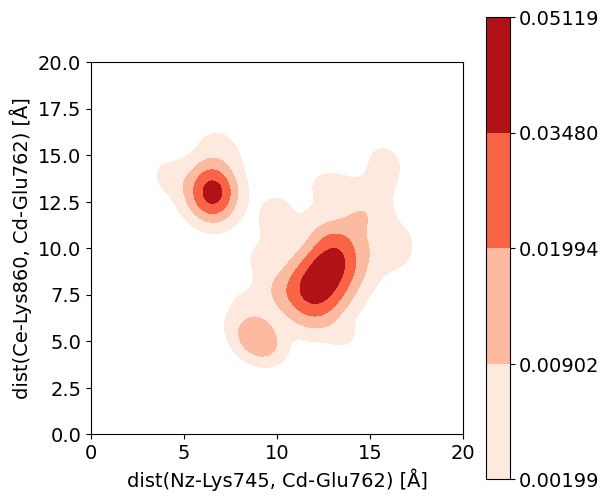

In [52]:
data = pd.DataFrame(dbdist_cat[::1000,:]*10, columns=['x', 'y'])
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=data, ax=ax, x='x', y='y', cbar=True, fill=True, cmap='Reds', levels=5)
ax.set_xlim([0,20])
ax.set_ylim([0,20])
ax.set_xlabel('dist(Nz-Lys745, Cd-Glu762) [Å]', fontsize=14)
ax.set_ylabel('dist(Ce-Lys860, Cd-Glu762) [Å]', fontsize=14)
ax.set_aspect('equal')

plt.show()

Hierachical clustering -- not good

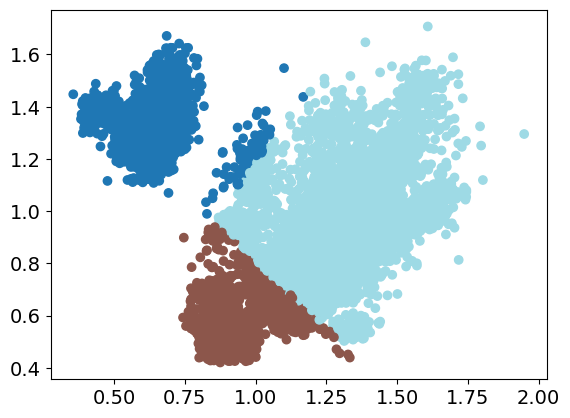

In [53]:
plt.scatter(dbdist_cat[::1000,0], dbdist_cat[::1000,1], c=distgroup_cat[::1000], cmap='tab20')

Gaussian mixture classification -- not good

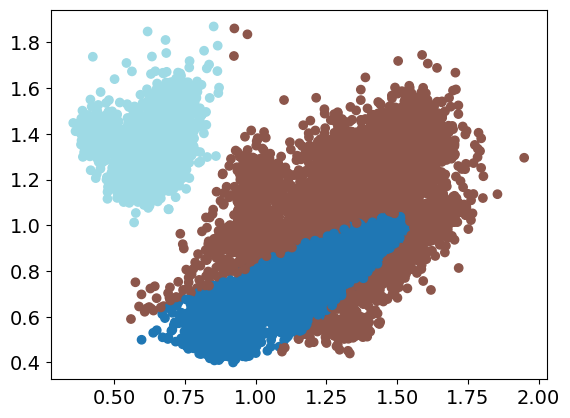

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(dbdist_cat[::500,:])
labels = gmm.predict(dbdist_cat[::500,:])
plt.scatter(dbdist_cat[::500,0], dbdist_cat[::500,1], c=labels, cmap='tab20')

Hdbscan looks good and robust with various cluster size

[-1  0  1  2]


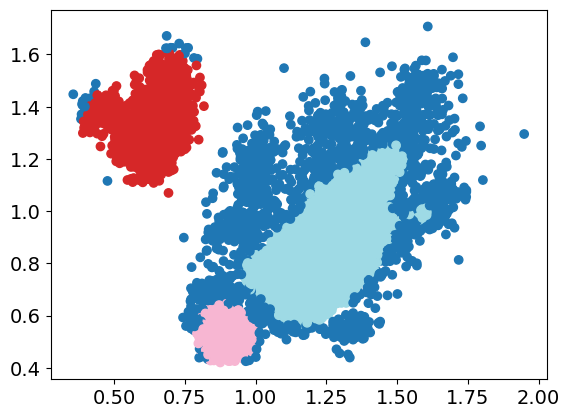

In [54]:
hdb = hdbscan.HDBSCAN(min_cluster_size=200, prediction_data=True)
hdb.fit(dbdist_cat[::1000,:])
print(np.unique(hdb.labels_))
plt.scatter(dbdist_cat[::1000,0], dbdist_cat[::1000,1], c=hdb.labels_, cmap='tab20')

In [55]:
def batch_predict(hdb, data, batch_size=100000):
    num_points = data.shape[0]
    predicted_labels = np.zeros(num_points, dtype=int) - 1  # Default to noise (-1)
    strengths = np.zeros(num_points)
    for i in tqdm(range(0, num_points, batch_size), total=num_points // batch_size):
        batch = data[i:i+batch_size]
        labels, strength = hdbscan.approximate_predict(hdb, batch)
        predicted_labels[i:i+batch_size] = labels
        strengths[i:i+batch_size] = strength
    return predicted_labels, strengths

# Run batch processing
predicted_labels, strengths = batch_predict(hdb, dbdist_cat, batch_size=100000)

119it [14:34,  7.35s/it]                         


In [57]:
with open(data_path / f'{protein}'/ 'clustering'/ 'hdbscan.pkl', 'wb') as f:
    pickle.dump(hdb, f)

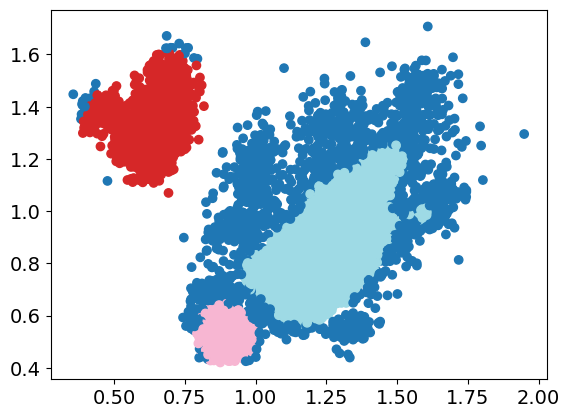

In [60]:
# Assign noise (-1) to low-confidence points
confidence_threshold = 0.001
filtered_labels = predicted_labels.copy()
filtered_labels[strengths < confidence_threshold] = -1
plt.scatter(dbdist_cat[::1000,0], dbdist_cat[::1000,1], c=filtered_labels[::1000], cmap='tab20')

In [ ]:
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(6, 6))
#scatter = ax.scatter(dbdist_cat[::100, 0], dbdist_cat[::100, 1], c=distgroup_cat[::100], cmap='tab10', s=0.3, alpha=0.5, label)
scatter = ax.scatter(dbdist_cat[np.ravel(filtered_labels) !=-1][::100, 0], dbdist_cat[np.ravel(filtered_labels) !=-1][::100, 1], c=filtered_labels[np.ravel(filtered_labels) !=-1][::100], cmap='tab10', s=0.3, alpha=0.5)

for cluster in [0,1,1]:
    cluster_points = dbdist_cat[np.ravel(filtered_labels) == cluster]
    if len(cluster_points) >= 3: 
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=2)


## EGFR
---

In [12]:
protein = 'egfr'
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data')

TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/egfr_processed/'),
               ftraj_dir= data_path / f'{protein}/ftrajs',
               dt=1,
               key='pdb-1ns')

TD.load_ftrajs(key='pdb-1ns',
               feature_names=['dbdist', 'distgroup'],)
dbdist, _ = TD.get_ftrajs(keys=['pdb-1ns'], 
                             dt_out=1, 
                             internal_names=['dbdist'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
distgroup, _ = TD.get_ftrajs(keys=['pdb-1ns'], 
                             dt_out=1, 
                             internal_names=['distgroup'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)

dbdist_cat = np.concatenate(dbdist, axis=0)
distgroup_cat = np.concatenate(distgroup, axis=0)

Setting dataset <pdb-1ns>. 
Number of raw trajectories: 3472

pdb-1ns
Loading feature:  dbdist


100%|██████████| 3472/3472 [00:00<00:00, 11332.81it/s]


Loading feature:  distgroup


100%|██████████| 3472/3472 [00:00<00:00, 12326.77it/s]


Stride for dataset pdb-1ns with timestep 1: 1
Preparing feature trajectories...


100%|██████████| 3472/3472 [00:00<00:00, 32258.45it/s]


Stride for dataset pdb-1ns with timestep 1: 1
Preparing feature trajectories...


100%|██████████| 3472/3472 [00:00<00:00, 33964.67it/s]


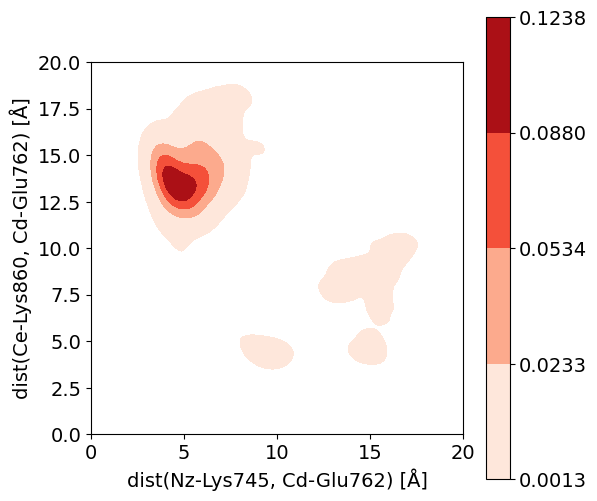

In [13]:
data = pd.DataFrame(dbdist_cat[::1000,:]*10, columns=['x', 'y'])
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=data, ax=ax, x='x', y='y', cbar=True, fill=True, cmap='Reds', levels=5)
ax.set_xlim([0,20])
ax.set_ylim([0,20])
ax.set_xlabel('dist(Nz-Lys745, Cd-Glu762) [Å]', fontsize=14)
ax.set_ylabel('dist(Ce-Lys860, Cd-Glu762) [Å]', fontsize=14)
ax.set_aspect('equal')
plt.show()

[-1  0  1  2]


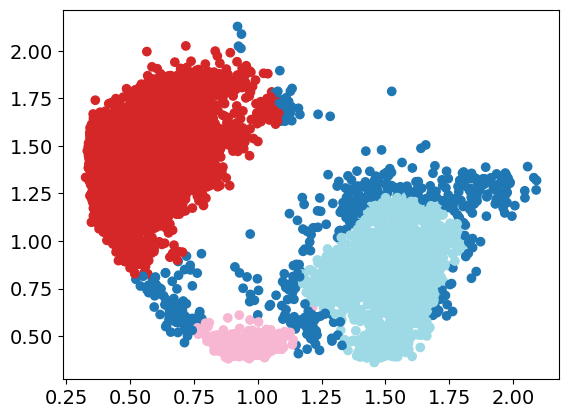

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=200, prediction_data=True)
hdb.fit(dbdist_cat[::1000,:])
with open(data_path / f'{protein}'/ 'clustering'/ 'hdbscan.pkl', 'wb') as f:
    pickle.dump(hdb, f)
print(np.unique(hdb.labels_))
plt.scatter(dbdist_cat[::1000,0], dbdist_cat[::1000,1], c=hdb.labels_, cmap='tab20')

In [21]:
def batch_predict(hdb, data, batch_size=100000):
    num_points = data.shape[0]
    predicted_labels = np.zeros(num_points, dtype=int) - 1  # Default to noise (-1)
    strengths = np.zeros(num_points)
    for i in tqdm(range(0, num_points, batch_size), total=num_points // batch_size):
        batch = data[i:i+batch_size]
        labels, strength = hdbscan.approximate_predict(hdb, batch)
        predicted_labels[i:i+batch_size] = labels
        strengths[i:i+batch_size] = strength
    return predicted_labels, strengths

# Run batch processing
predicted_labels, strengths = batch_predict(hdb, dbdist_cat, batch_size=100000)

368it [52:07,  8.50s/it]                         


(0.0, 2.5)

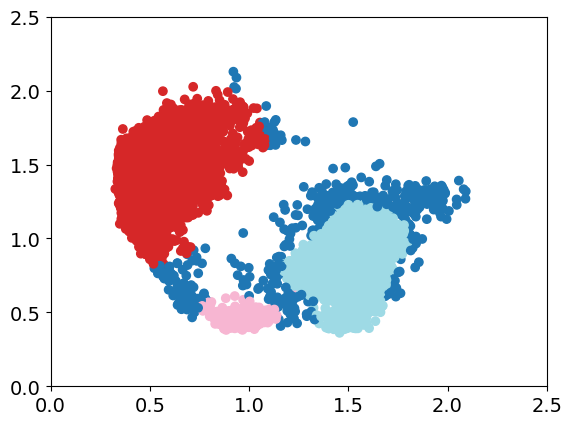

In [47]:
# Assign noise (-1) to low-confidence points
confidence_threshold = 0.01
filtered_labels = predicted_labels.copy()
filtered_labels[strengths < confidence_threshold] = -1
plt.scatter(dbdist_cat[::1000,0], dbdist_cat[::1000,1], c=filtered_labels[::1000], cmap='tab20')
plt.xlim([0,2.5])
plt.ylim([0,2.5])

(0.0, 2.5)

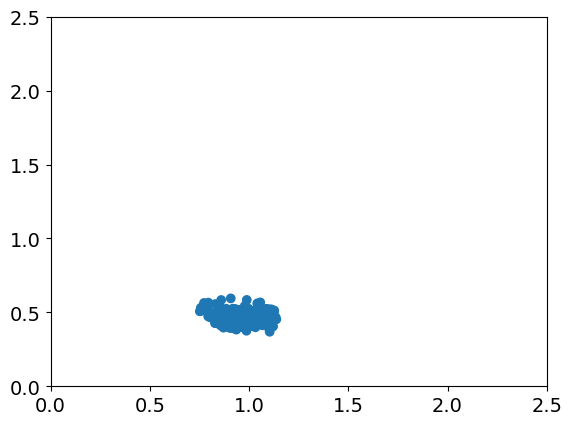

In [48]:
plt.scatter(dbdist_cat[filtered_labels == 1][::1000,0], dbdist_cat[filtered_labels == 1][::1000,1], c=filtered_labels[filtered_labels == 1][::1000], cmap='tab20')
plt.xlim([0,2.5])
plt.ylim([0,2.5])

Alternativel train a k-NN to classify the remaining points

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

sampled_data = dbdist_cat[::1000, :]
sampled_labels = hdb.labels_

# Filter out noise points (-1) from sampled data
mask = sampled_labels != -1
X_train = sampled_data[mask]
y_train = sampled_labels[mask]

# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
predicted_labels = knn.predict(dbdist_cat)

In [20]:
with open(data_path / f'{protein}'/ 'clustering'/ 'knn.pkl', 'wb') as f:
    pickle.dump(knn, f)

In [41]:
# Optional: Assign low-confidence predictions to noise (-1)
probs = knn.predict_proba(dbdist_cat)
confidence_threshold = 0.1  # Adjust as needed
filtered_labels = predicted_labels.copy()
filtered_labels[np.max(probs, axis=1) < confidence_threshold] = -1

(0.0, 3.0)

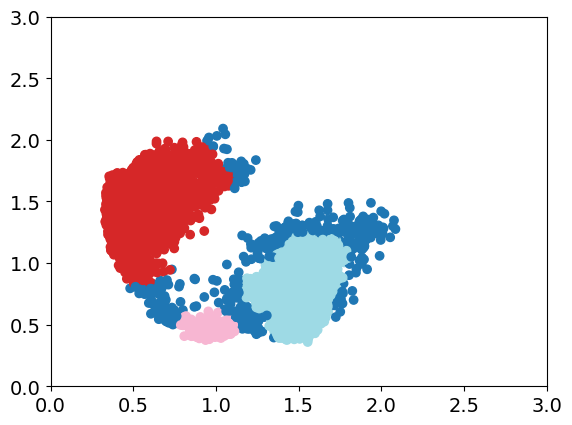

In [42]:
plt.scatter(dbdist_cat[2::1000,0], dbdist_cat[2::1000,1], c=filtered_labels[2::1000], cmap='tab20')
plt.xlim([0,3])
plt.ylim([0,3])

(0.0, 3.0)

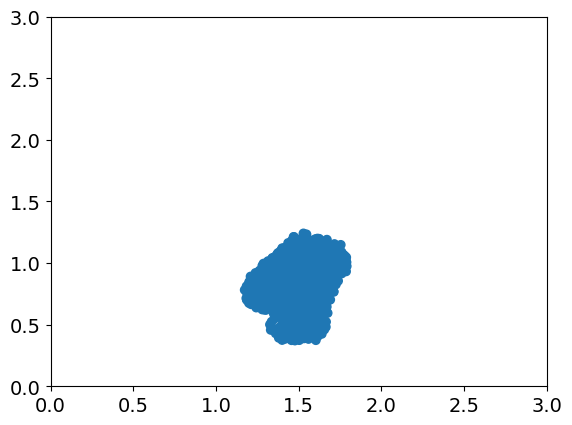

In [43]:
# check if labels are correct
plt.scatter(dbdist_cat[predicted_labels==2][2::1000,0], dbdist_cat[predicted_labels==2][2::1000,1], c=filtered_labels[predicted_labels==2][2::1000], cmap='tab20')
plt.xlim([0,3])
plt.ylim([0,3])